In [1]:
setwd("~/projects/next_gen_attribution/src/analysis/R/pg")

source("~/R_connector/libraries.R")
#mozart <- connToEDW(dataBase = "Mozart", connType = 'normal', user = 'pgurican', pass=trimws(read_file("~/R_connector/p.txt")))
hopper <- connToEDW(dataBase = "Hopper", connType = 'normal', user = 'pgurican', pass=trimws(read_file("~/R_connector/p.txt")))

Loading required package: DBI
Loading required package: rJava
------------------------------------------------------------------------------
data.table + dplyr code now lives in dtplyr.
Please library(dtplyr)!
------------------------------------------------------------------------------

Attaching package: ‘dplyr’

The following objects are masked from ‘package:data.table’:

    between, first, last

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [23]:
mktng_events <- dbGetQuery(conn = hopper, "select * from P_attribution_T.pg_agg_mktng_evts_v2;")

In [24]:
mktng_events <- mktng_events %>% select(-dt)

In [25]:
head(mktng_events)

event_dt,channel_id,event_type_id,no_events
2017-06-20,NA,7,15
2017-06-01,NA,7,17
2017-05-21,NA,7,15
2017-06-22,NA,7,178
2017-06-03,NA,7,18
2017-05-04,NA,7,9


In [26]:
mktng_events$event_dt <- as.Date(mktng_events$event_dt)

In [27]:
mktng_events$channel_id <- as.factor(mktng_events$channel_id)

In [28]:
mktng_events$event_type_id <- as.factor(mktng_events$event_type_id)

In [29]:
mktng_events %>% filter(event_dt >= as.Date("2017-06-08")) %>% filter(event_dt <= as.Date("2017-06-13")) %>% filter(channel_id == 1) %>% select(event_dt, event_type_id, no_events) %>%arrange(event_dt)

event_dt,event_type_id,no_events
2017-06-08,4,183608841
2017-06-08,7,31719
2017-06-08,1,1556088
2017-06-10,4,134544328
2017-06-10,7,32639
2017-06-10,1,1554506
2017-06-11,4,153332984
2017-06-11,7,27538
2017-06-11,1,1619818
2017-06-12,4,191548159


In [8]:
events_by_date_channel <- mktng_events %>% 
                                    select(-event_type_id) %>% 
                                    group_by(event_dt, channel_id) %>% 
                                    summarise(no_events = sum(no_events))

In [9]:
events_by_date_channel %>% filter(event_dt == as.Date('2017-05-01')) %>% arrange(desc(no_events))

event_dt,channel_id,no_events
2017-05-01,1,135282500
2017-05-01,50,84689238
2017-05-01,2,44042465
2017-05-01,NA,26136328
2017-05-01,40,24098891
2017-05-01,3,23753529
2017-05-01,33,21860818
2017-05-01,6,14147959
2017-05-01,15,2657644
2017-05-01,13,1711405


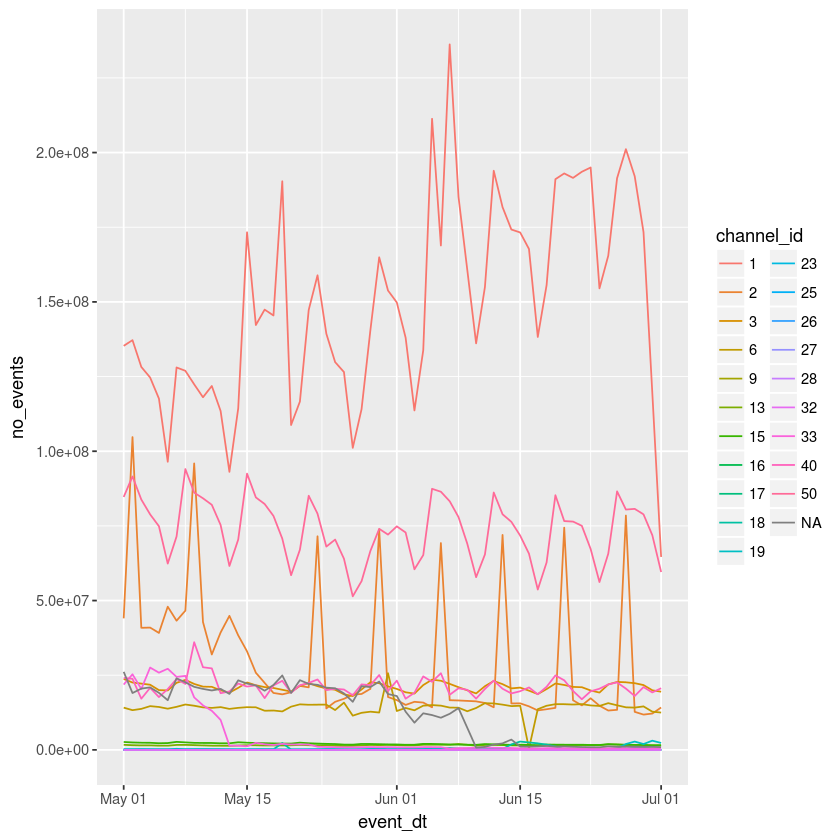

In [10]:
ggplot(events_by_date_channel, aes(x = event_dt, y = no_events, group = channel_id, color = channel_id)) + geom_line()

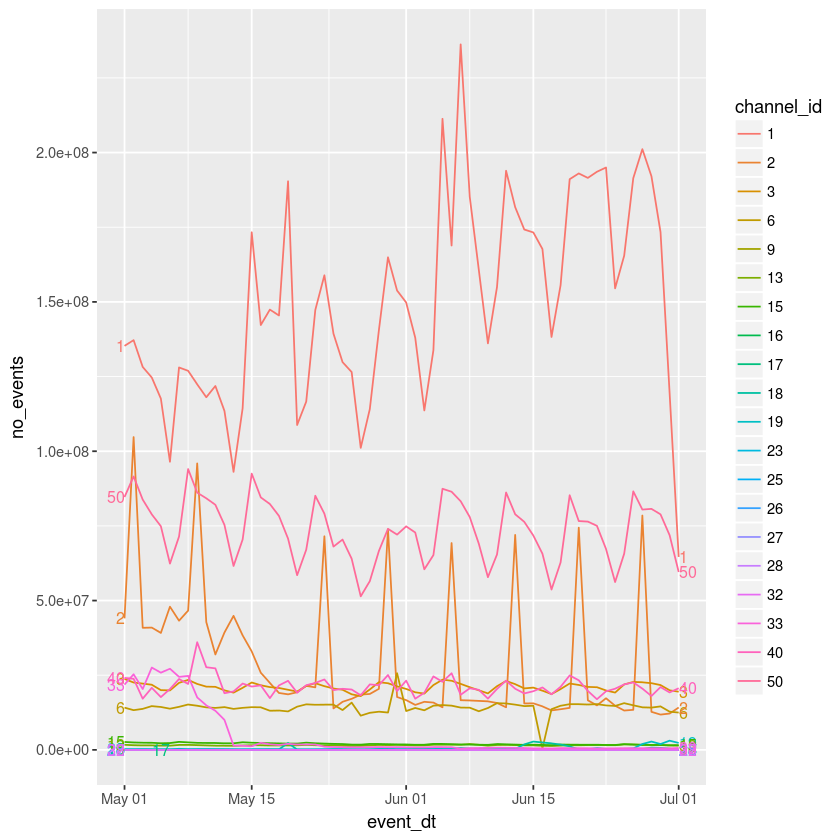

In [12]:
library(directlabels)

ggplot(events_by_date_channel %>% filter(!is.na(channel_id)), aes(x = event_dt, y = no_events, group = channel_id, color = channel_id, fill = channel_id)) +
    geom_line() +
    geom_dl(aes(label = channel_id), method = list(dl.combine("first.points", "last.points"), cex = 0.8)) 


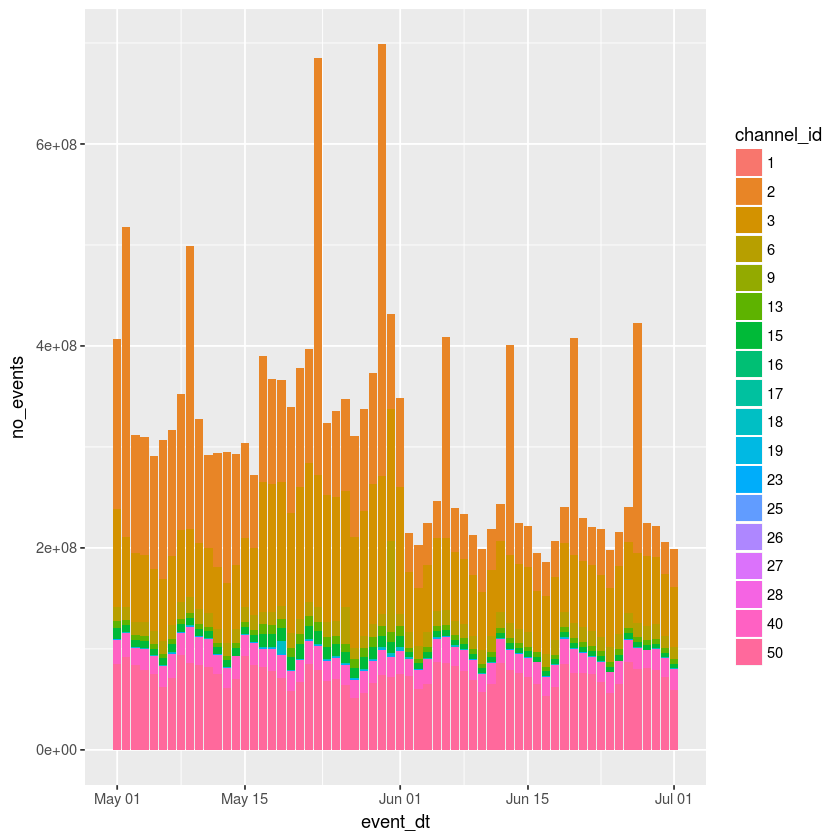

In [13]:
ggplot(events_by_date_channel %>% filter(!is.na(channel_id)), aes(x = event_dt, y = no_events, fill = channel_id)) +
    geom_bar(stat='identity')

In [14]:
mktng_events_txns_df <- dbGetQuery(conn = hopper, "select * from P_attribution_T.pg_mktng_txns_corr;")

In [15]:
head(mktng_events_txns_df)

event_dt,channel_id,event_type_id,join_strategy,no_events,mktng_dt
2017-06-20,NA,1,xid,169890,2017-06-20
2017-06-01,NA,1,xid,260694,2017-06-01
2017-05-21,NA,1,xid,368250,2017-05-21
2017-06-22,NA,1,xid,304254,2017-06-22
2017-06-03,NA,1,xid,127377,2017-06-03
2017-05-04,NA,1,xid,215460,2017-05-04


In [16]:
sum(mktng_events$no_events)
sum(mktng_events_txns_df$no_events)

[1] 59404630137

[1] 9000908778

In [17]:
head(events_by_date_channel %>% 
                            group_by(channel_id, event_dt) %>% 
                            summarise(daily_events = sum(no_events)))

channel_id,event_dt,daily_events
1,2017-05-01,13232
1,2017-05-02,9360
1,2017-05-03,9570
1,2017-05-04,9567
1,2017-05-05,8271
1,2017-05-06,9315


In [18]:
daily_proportions_mktng <- events_by_date_channel %>% 
                            group_by(event_dt) %>% 
                            mutate(prop = no_events / sum(no_events) * 100)

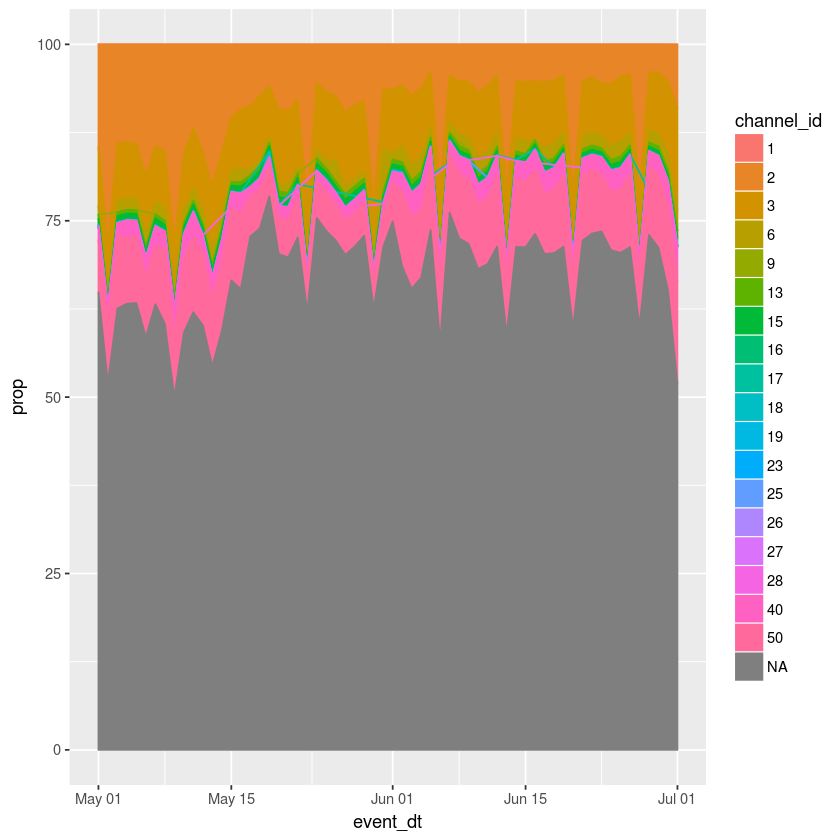

In [19]:
ggplot(data = daily_proportions_mktng, 
       aes(x = event_dt, 
           y = prop, 
           group = channel_id, 
           colour = channel_id, 
           fill = channel_id)) + 
    geom_area()

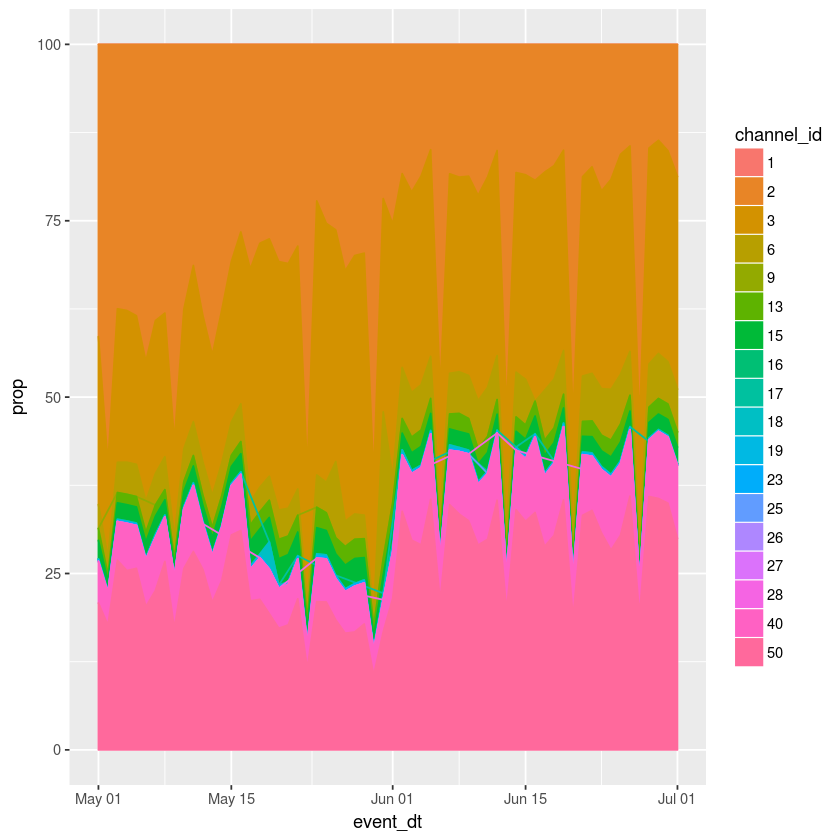

In [20]:
d <- events_by_date_channel %>% 
        filter(!is.na(channel_id)) %>%
                            group_by(event_dt) %>% 
                            mutate(prop = no_events / sum(no_events) * 100)

ggplot(data = d, 
       aes(x = event_dt, 
           y = prop, 
           group = channel_id, 
           colour = channel_id, 
           fill = channel_id)) + 
    geom_area()

In [21]:
mktng_events_txns_df <- mktng_events_txns_df %>% select(-mktng_dt)
mktng_events_txns_df$event_dt <- as.Date(mktng_events_txns_df$event_dt)
mktng_events_txns_df$channel_id <- as.factor(mktng_events_txns_df$channel_id)
mktng_events_txns_df$event_type_id <- as.factor(mktng_events_txns_df$event_type_id)
mktng_events_txns_df$join_strategy <- as.factor(mktng_events_txns_df$join_strategy)

In [22]:
head(mktng_events_txns_df)

event_dt,channel_id,event_type_id,join_strategy,no_events
2017-06-20,NA,1,xid,169890
2017-06-01,NA,1,xid,260694
2017-05-21,NA,1,xid,368250
2017-06-22,NA,1,xid,304254
2017-06-03,NA,1,xid,127377
2017-05-04,NA,1,xid,215460


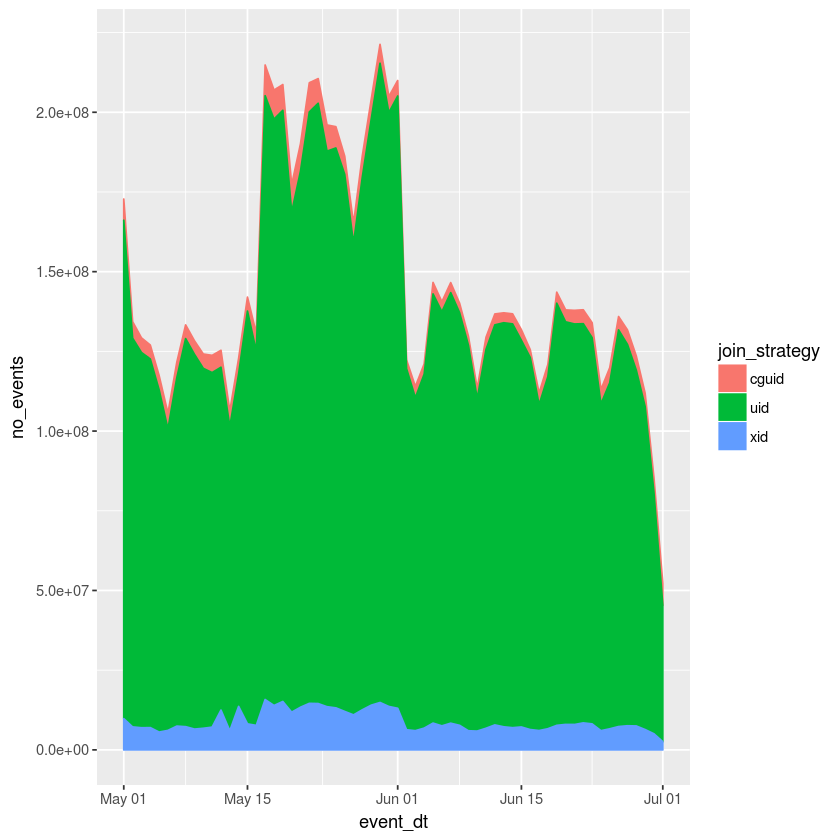

In [23]:
d <- mktng_events_txns_df %>% 
        group_by(event_dt, join_strategy) %>% 
        summarise(no_events = sum(no_events))

ggplot(data = d,
       aes(x = event_dt,
           y = no_events,
           group = join_strategy,
           fill = join_strategy,
           colour = join_strategy)) + 
    geom_area()

In [24]:
sum(mktng_events_txns_df$no_events)

[1] 9000908778

In [13]:
channels_lookup <- read.csv(file = "channels_lookup.csv")

In [14]:
channels_lookup$channel_id <- as.factor(channels_lookup$channel_id)
channels_lookup$channel_name <- as.factor(channels_lookup$channel_name)

In [27]:
mktng_events_txns_df <- left_join(mktng_events_txns_df, channels_lookup)

Joining, by = "channel_id"
Warning message in left_join_impl(x, y, by$x, by$y, suffix$x, suffix$y):
“joining factors with different levels, coercing to character vector”

In [28]:
mktng_events_txns_df %>% filter(!is.na(channel_id))

event_dt,channel_id,event_type_id,join_strategy,no_events,channel_name
2017-05-04,1,1,cguid,84,Display
2017-05-11,1,1,uid,810,Display
2017-05-03,1,1,cguid,36,Display
2017-05-09,1,1,cguid,6,Display
2017-05-01,1,1,uid,1192,Display
2017-05-08,1,1,cguid,6,Display
2017-05-07,1,1,cguid,6,Display
2017-05-10,1,1,uid,978,Display
2017-05-02,1,1,uid,1242,Display
2017-06-20,1,1,uid,1431,Display


In [32]:
mktng_events <- left_join(mktng_events, channels_lookup)

Joining, by = "channel_id"
Warning message in left_join_impl(x, y, by$x, by$y, suffix$x, suffix$y):
“joining factors with different levels, coercing to character vector”

In [16]:
is.factor(mktng_events$channel_name)

[1] TRUE

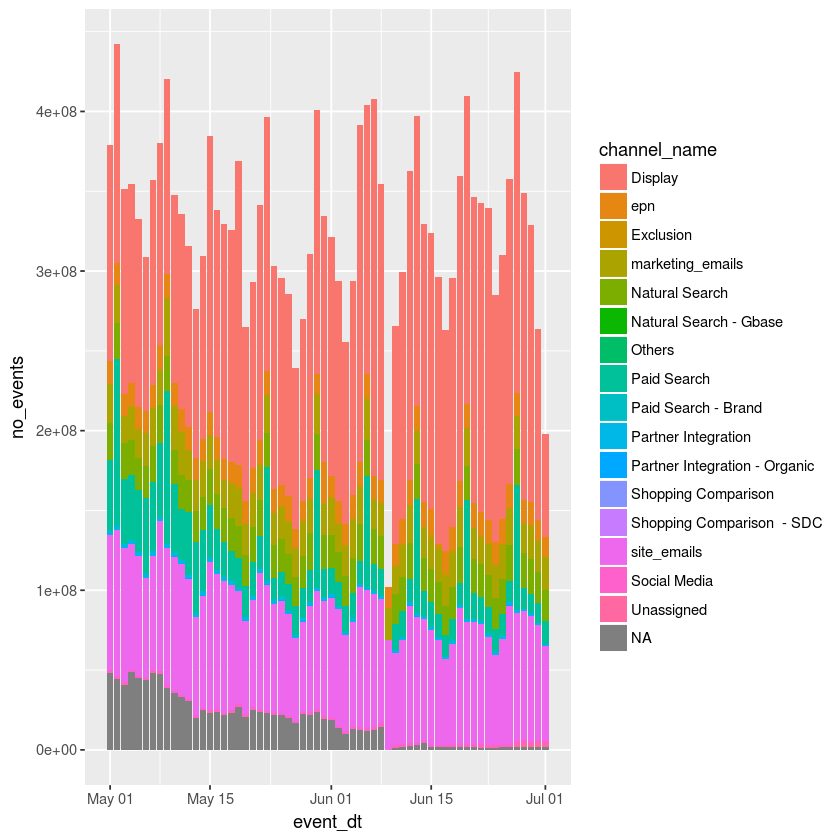

In [68]:
d <- mktng_events %>% 
        select(-event_type_id, channel_id) %>% 
        group_by(event_dt, channel_name) %>% 
        summarise(no_events = sum(no_events))

ggplot(d, aes(x = event_dt, y = no_events, fill = channel_name)) +
    geom_bar(stat='identity')

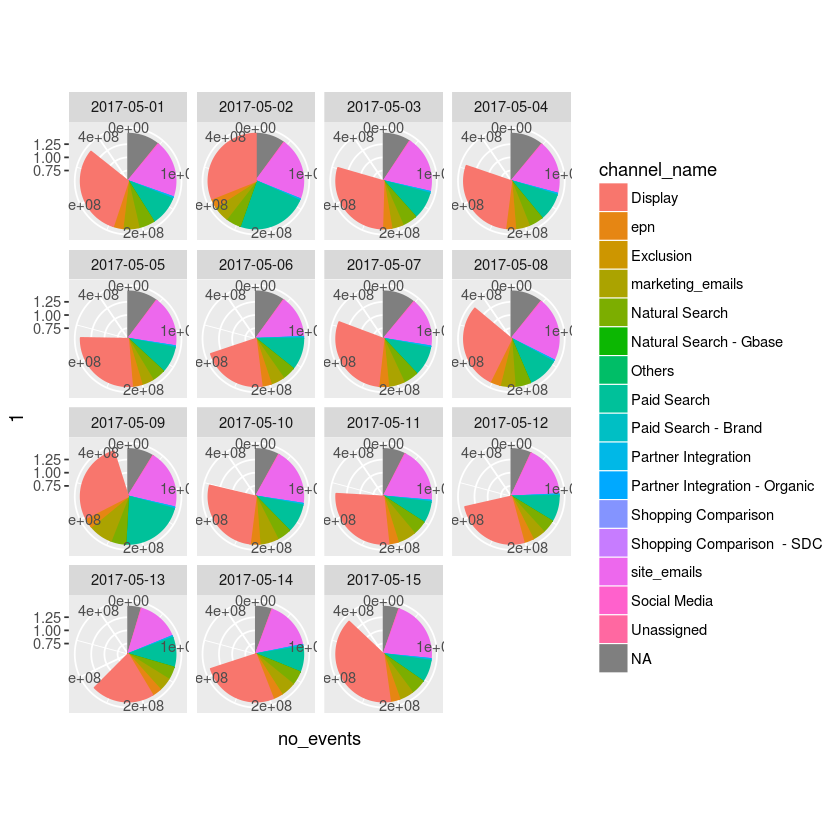

In [45]:
d <- mktng_events %>% 
        select(-event_type_id, channel_id) %>% 
        group_by(event_dt, channel_name) %>% 
        summarise(no_events = sum(no_events)) %>%
        filter(event_dt <= as.Date("2017-05-15"))
        

ggplot(d, 
       aes(x = 1, 
           y = no_events, 
           fill = channel_name, 
           colour = channel_name, 
           group = channel_name)) +
    geom_col() +
    coord_polar(theta = "y") +
    facet_wrap(~ event_dt)

In [72]:
d <- mktng_events %>% 
        select(-event_type_id, channel_id) %>% 
        group_by(event_dt, channel_name) %>% 
        summarise(daily_events_channel = sum(no_events)) %>%
        ungroup(channel_name) %>%
        group_by(event_dt) %>%
        mutate(daily_events = sum(daily_events_channel))



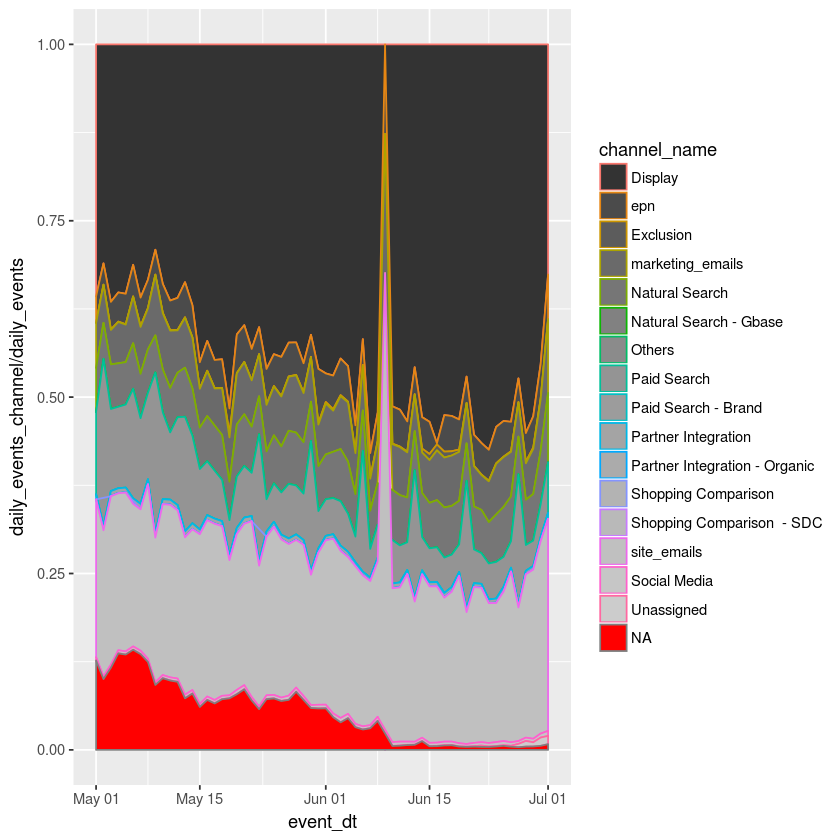

In [82]:
ggplot(d, 
       aes(x = event_dt, 
           y = daily_events_channel/daily_events, 
           fill = channel_name, 
           colour = channel_name, 
           group = channel_name)) +
    geom_area() +
    scale_fill_grey() #+
    #scale_colour_grey()

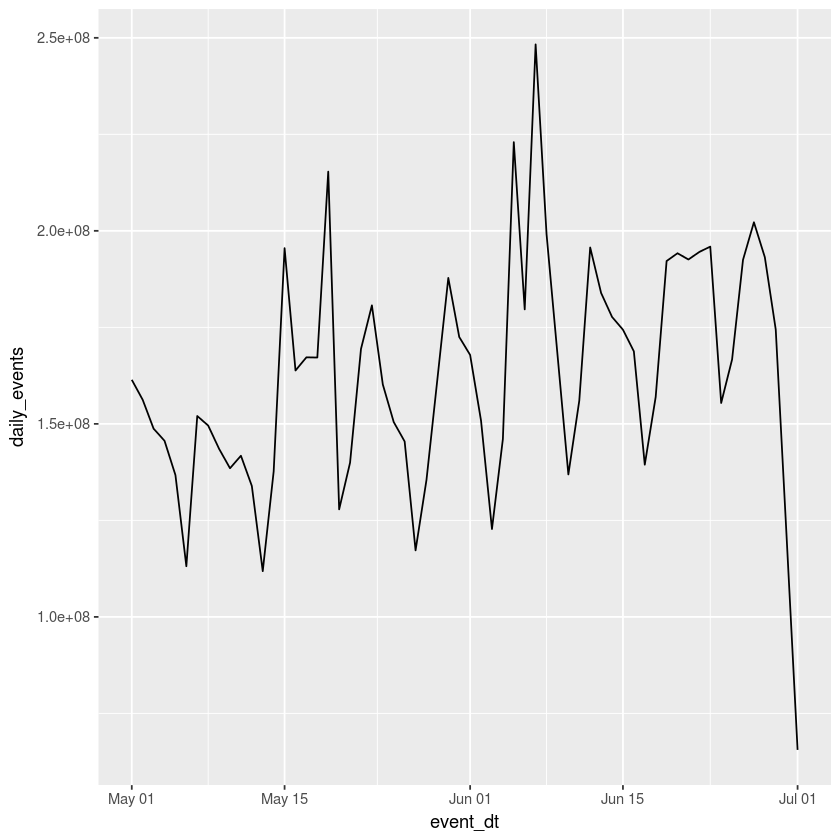

In [87]:
ggplot(data = mktng_events %>% filter(channel_id == 1 | is.na(channel_id)) %>%
    group_by(event_dt) %>%
    summarise(daily_events = sum(no_events)),
       aes(x = event_dt,
           y = daily_events)) + 
    geom_line()

In [76]:
(d %>% filter(event_dt == "2017-05-15"))$daily_events_channel / (d %>% filter(event_dt == "2017-05-15"))$daily_events*100

[1] 4.504798e+01 3.720308e+00 4.138820e-02 5.512283e+00 5.866271e+00
 [6] 3.872987e-05 4.400649e-04 8.571913e+00 6.528973e-03 6.270325e-01
[11] 3.860329e-02 5.198641e-07 3.587062e-05 2.404533e+01 4.131087e-01
[16] 2.550115e-02 6.083238e+00

In [21]:
mktng_events %>% filter(event_dt >= as.Date("2017-06-08")) %>% filter(event_dt <= as.Date("2017-06-13")) %>% filter(channel_id == 1) %>% select(event_dt, event_type_id, channel_name, no_events) %>% arrange(event_dt)

event_dt,event_type_id,channel_name,no_events
2017-06-08,4,Display,183608841
2017-06-08,7,Display,31719
2017-06-08,1,Display,1556088
2017-06-10,4,Display,134544328
2017-06-10,7,Display,32639
2017-06-10,1,Display,1554506
2017-06-11,4,Display,153332984
2017-06-11,7,Display,27538
2017-06-11,1,Display,1619818
2017-06-12,4,Display,191548159


In [22]:
mktng_events %>% filter(event_dt >= as.Date("2017-06-14")) %>% filter(event_dt <= as.Date("2017-06-18")) %>% filter(channel_id == 6) %>% select(event_dt, event_type_id, channel_name, no_events) %>%arrange(event_dt)

event_dt,event_type_id,channel_name,no_events
2017-06-14,1,epn,14663768
2017-06-14,7,epn,37
2017-06-15,1,epn,14785311
2017-06-15,7,epn,69
2017-06-16,1,epn,455696
2017-06-16,7,epn,67
2017-06-17,1,epn,13633045
2017-06-17,7,epn,83
2017-06-18,1,epn,14783992
2017-06-18,7,epn,76


In [32]:
daily_counts <- mktng_events %>% group_by(event_dt) %>% summarise(no_events = sum(no_events))
daily_na_counts <- mktng_events %>% filter(is.na(channel_id)) %>% group_by(event_dt) %>% summarise(no_events = sum(no_events))

In [33]:
daily_na_counts
daily_counts

event_dt,no_events
2017-05-01,750712768
2017-05-02,560195091
2017-05-03,521572377
2017-05-04,534001449
2017-05-05,502982712
2017-05-06,432963081
2017-05-07,542370159
2017-05-08,537072147
2017-05-09,498859146
2017-05-10,474800322


event_dt,no_events
2017-05-01,1157570854
2017-05-02,1077530112
2017-05-03,833485751
2017-05-04,844326657
2017-05-05,793987728
2017-05-06,739988477
2017-05-07,858761041
2017-05-08,889099909
2017-05-09,997826866
2017-05-10,802577004


In [34]:
NA_props<- data.frame(event_dt = as.Date(seq(from = as.Date("2017-05-01"), to = as.Date("2017-07-01"), by =1)),
                 prop = daily_na_counts$no_events / daily_counts$no_events)

In [35]:
NA_props

event_dt,prop
2017-05-01,0.6485242
2017-05-02,0.5198881
2017-05-03,0.6257724
2017-05-04,0.6324584
2017-05-05,0.6334893
2017-05-06,0.5850944
2017-05-07,0.6315729
2017-05-08,0.6040628
2017-05-09,0.4999456
2017-05-10,0.5915947


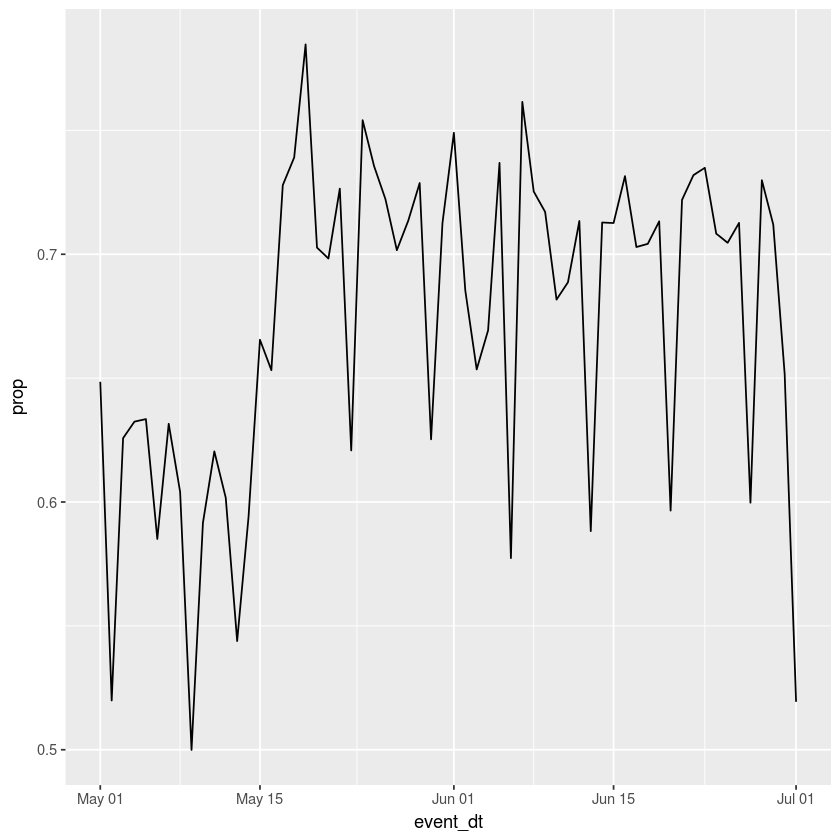

In [36]:
ggplot(data = NA_props, aes(x = event_dt, y = prop)) + geom_line()